In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

In [16]:
df = pd.read_csv('data/transformed_data.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,week,day,hour
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,1,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,1,1,0
2,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,1,1,0
3,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,1,1,0
4,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2151490,718,PAYMENT,8178.01,C1213413071,11742.0,3563.99,M1112540487,0.0,0.0,5,30,21
2151491,718,PAYMENT,17841.23,C1045048098,10182.0,0.00,M1878955882,0.0,0.0,5,30,21
2151492,718,PAYMENT,1022.91,C1203084509,12.0,0.00,M675916850,0.0,0.0,5,30,21
2151493,718,PAYMENT,4109.57,C673558958,5521.0,1411.43,M1126011651,0.0,0.0,5,30,21


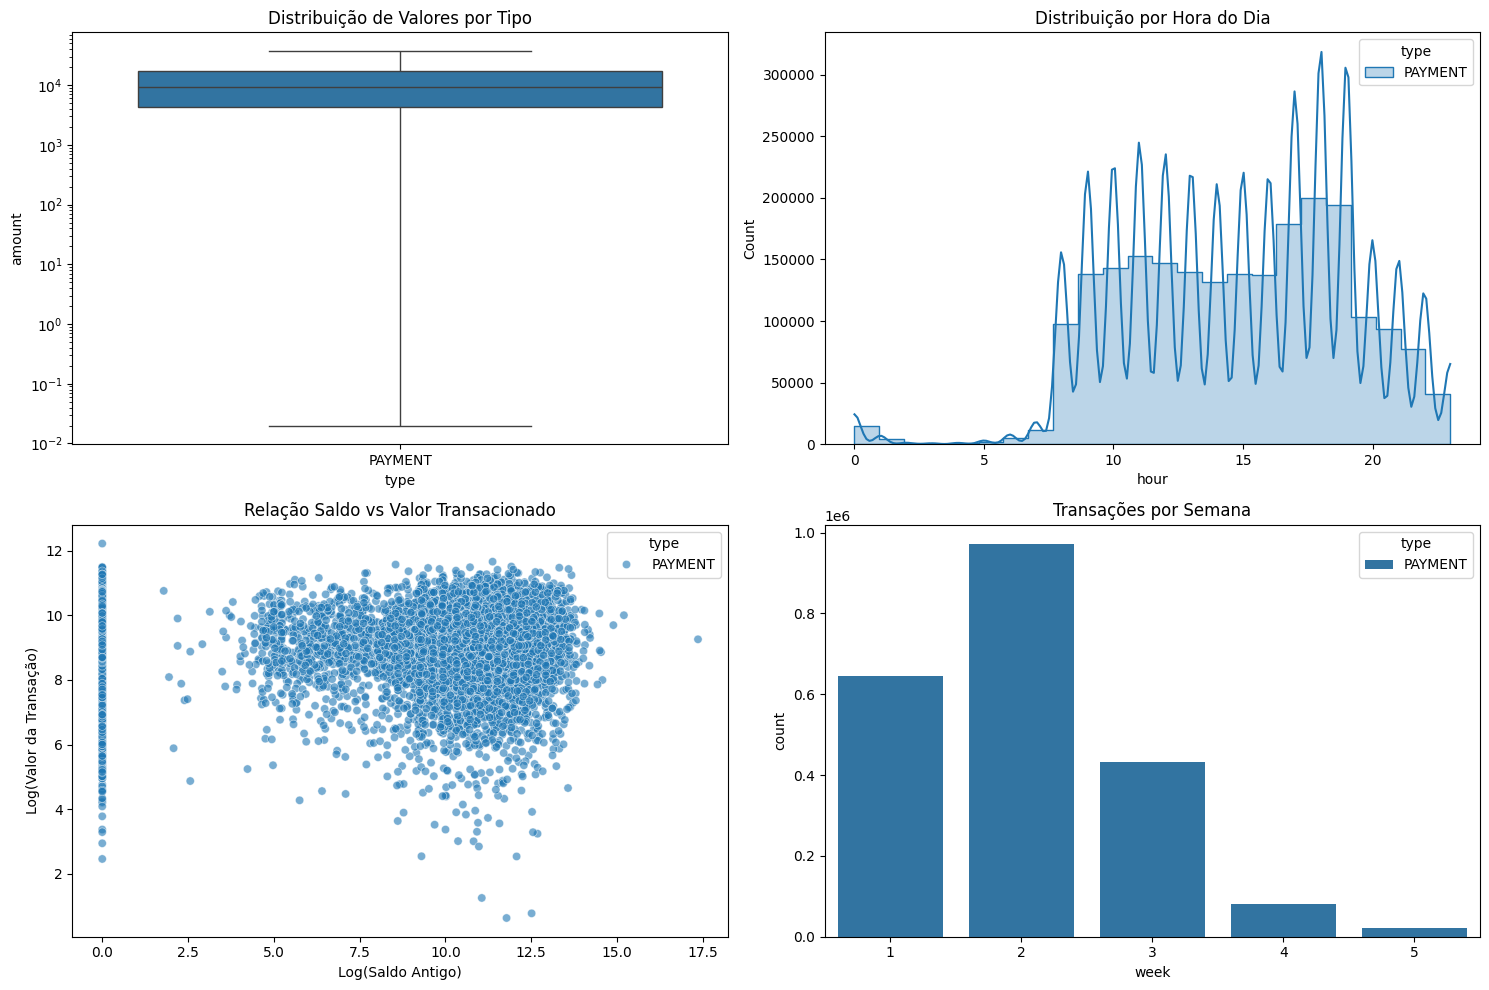

In [17]:
plt.figure(figsize=(15, 10))

# Distribuição de valores por tipo
plt.subplot(2, 2, 1)
sns.boxplot(x='type', y='amount', data=df, showfliers=False)
plt.yscale('log')
plt.title('Distribuição de Valores por Tipo')

# Padrão temporal
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='hour', hue='type', bins=24, 
             element='step', kde=True, alpha=0.3)
plt.title('Distribuição por Hora do Dia')

# Relação saldo vs transação
plt.subplot(2, 2, 3)
sample = df.sample(10000)
sns.scatterplot(x=np.log1p(sample['oldbalanceOrg']), 
                y=np.log1p(sample['amount']), 
                hue='type', alpha=0.6, data=sample)
plt.title('Relação Saldo vs Valor Transacionado')
plt.xlabel('Log(Saldo Antigo)')
plt.ylabel('Log(Valor da Transação)')

# Frequência semanal
plt.subplot(2, 2, 4)
sns.countplot(x='week', hue='type', data=df)
plt.title('Transações por Semana')

plt.tight_layout()
plt.show()


In [31]:
# Ordenar por conta e passo temporal
df = df.sort_values(['nameOrig', 'step'])

# Calcular mudança de saldo REAL (versão otimizada)
def calculate_balance_change(group):
    try:
        # Primeiro saldo disponível (conta ORIGEM)
        initial_balance = group['oldbalanceOrg'].iloc[0]
        
        # Último saldo disponível (conta ORIGEM)
        final_balance = group['newbalanceOrig'].iloc[-1]
        
        # Valor líquido movimentado
        net_change = final_balance - initial_balance
        
        # Valor total debitado
        total_debited = group.loc[group['type'] == 'DEBIT', 'amount'].sum()
        
        # Valor total creditado (pagamentos)
        total_credited = group.loc[group['type'] == 'PAYMENT', 'amount'].sum()
        
        # Calcular imbalance ratio com proteção contra divisão por zero
        imbalance_ratio = (total_debited - total_credited) / (initial_balance + 0.01)
        
        return pd.Series({
            'initial_balance': initial_balance,
            'final_balance': final_balance,
            'net_balance_change': net_change,
            'total_debited': total_debited,
            'total_credited': total_credited,
            'imbalance_ratio': imbalance_ratio
        })
    except Exception as e:
        print(f"Erro no grupo {group.name}: {e}")
        return pd.Series()  # Retorna Series vazia para grupos problemáticos

# Aplicar função de cálculo e remover grupos vazios
balance_features = df.groupby('nameOrig').apply(calculate_balance_change).reset_index()
balance_features = balance_features.dropna()  # Remover linhas com valores nulos

# 1. Primeiro: criar account_features básico
account_features_basic = df.groupby('nameOrig').agg(
    transaction_count=('amount', 'count'),
    avg_amount=('amount', 'mean'),
    median_amount=('amount', 'median'),
    amount_std=('amount', 'std'),
    payment_ratio=('type', lambda x: (x == 'PAYMENT').mean()),
    debit_ratio=('type', lambda x: (x == 'DEBIT').mean()),
    avg_hour=('hour', 'mean'),
    nighttime_ratio=('hour', lambda x: ((x >= 22) | (x <= 6)).mean()),
    weekly_frequency=('week', 'nunique')
).reset_index()

# 2. Juntar com balance_features
account_features = account_features_basic.merge(
    balance_features, 
    on='nameOrig', 
    how='left'
)

# 3. Preencher valores nulos resultantes da junção
for col in ['initial_balance', 'final_balance', 'net_balance_change', 
            'total_debited', 'total_credited', 'imbalance_ratio']:
    account_features[col] = account_features[col].fillna(0)

# 4. Verificar resultado
print(f"Contas no account_features_basic: {len(account_features_basic)}")
print(f"Contas no balance_features: {len(balance_features)}")
print(f"Contas no account_features final: {len(account_features)}")
print("\nExemplo de linhas:")
print(account_features.head(3))

C:\Users\joaop\AppData\Local\Temp\ipykernel_41548\3173909773.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balance_features = df.groupby('nameOrig').apply(calculate_balance_change).reset_index()


Contas no account_features_basic: 2150401
Contas no balance_features: 2150401
Contas no account_features final: 2150401

Exemplo de linhas:
      nameOrig  transaction_count  avg_amount  median_amount  amount_std  \
0  C1000001337                  1     3170.28        3170.28         NaN   
1  C1000001725                  1     8424.74        8424.74         NaN   
2  C1000006873                  1     4615.66        4615.66         NaN   

   payment_ratio  debit_ratio  avg_hour  nighttime_ratio  weekly_frequency  \
0            1.0          0.0       0.0              1.0                 1   
1            1.0          0.0      21.0              0.0                 1   
2            1.0          0.0      11.0              0.0                 1   

   initial_balance  final_balance  net_balance_change  total_debited  \
0          58089.0       54918.72            -3170.28            0.0   
1            783.0           0.00             -783.00            0.0   
2            313.0        

In [36]:
# Fill missing values
account_features.fillna(0, inplace=True)

In [37]:
account_features.head()

,nameOrig,transaction_count,avg_amount,median_amount,amount_std,payment_ratio,debit_ratio,avg_hour,nighttime_ratio,weekly_frequency,initial_balance,final_balance,net_balance_change,total_debited,total_credited,imbalance_ratio
0,C1000001337,1,3170.28,3170.28,0.0,1.0,0.0,0.0,1.0,1,58089.00,54918.72,-3170.28,0.0,3170.28,-0.054576
1,C1000001725,1,8424.74,8424.74,0.0,1.0,0.0,21.0,0.0,1,783.00,0.00,-783.00,0.0,8424.74,-10.759428
2,C1000006873,1,4615.66,4615.66,0.0,1.0,0.0,11.0,0.0,1,313.00,0.00,-313.00,0.0,4615.66,-14.746046
3,C1000008111,1,13925.55,13925.55,0.0,1.0,0.0,13.0,0.0,1,31295.00,17369.45,-13925.55,0.0,13925.55,-0.444977
4,C1000009135,1,3849.38,3849.38,0.0,1.0,0.0,18.0,0.0,1,103120.55,99271.17,-3849.38,0.0,3849.38,-0.037329


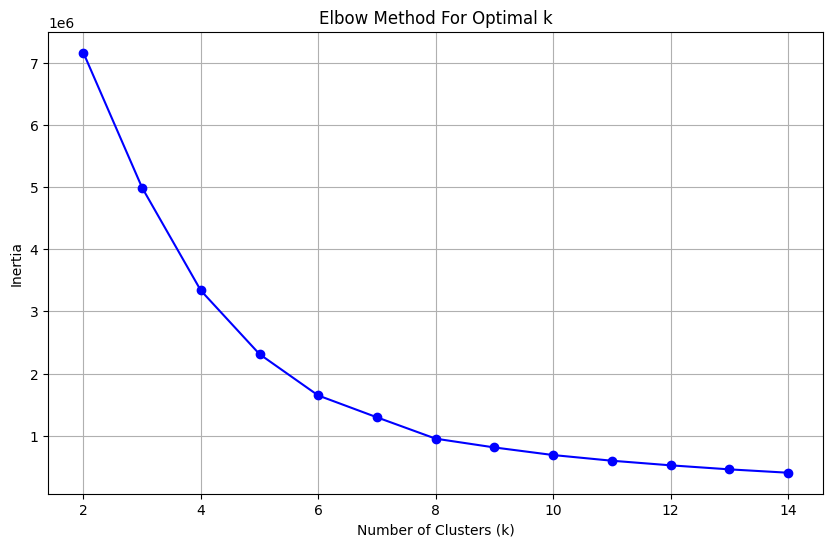

Inertia values:
k = 2: Inertia = 7162116.03
k = 3: Inertia = 4990988.14
k = 4: Inertia = 3336257.09
k = 5: Inertia = 2311908.09
k = 6: Inertia = 1646667.33
k = 7: Inertia = 1295207.42
k = 8: Inertia = 951609.24
k = 9: Inertia = 810345.15
k = 10: Inertia = 688207.26
k = 11: Inertia = 596875.11
k = 12: Inertia = 522694.06
k = 13: Inertia = 457868.03
k = 14: Inertia = 403638.82


In [40]:
# Select and transform features
features = [
    'transaction_count', 'avg_amount', 'amount_std', 
    'payment_ratio', 'nighttime_ratio', 'weekly_frequency',
    'imbalance_ratio'
]

# Apply log transformation to reduce skewness
X = account_features[features].copy()
X['transaction_count'] = np.log1p(X['transaction_count'])
X['avg_amount'] = np.log1p(X['avg_amount'])
X['amount_std'] = np.log1p(X['amount_std'].replace(0, 0.01))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate inertia for different k values
inertias = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Manual selection based on elbow point
print("Inertia values:")
for k, inertia in zip(k_range, inertias):
    print(f"k = {k}: Inertia = {inertia:.2f}")

In [41]:
def find_elbow_point(inertias):
    """Automatically detect elbow point using second derivative"""
    diff = np.diff(inertias)
    diff_ratio = diff[1:] / diff[:-1]
    elbow = np.argmin(diff_ratio) + 3  # +3 because we start from k=2
    return min(elbow, len(inertias) + 1)

optimal_k = find_elbow_point(inertias)
print(f"\nAutomatically detected elbow at k = {optimal_k}")


Automatically detected elbow at k = 8


In [42]:
# Apply KMeans with selected k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
account_features['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Selected clusters: {optimal_k}")

Selected clusters: 8


C:\Users\joaop\AppData\Local\Temp\ipykernel_41548\1870130561.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('cluster').apply(calculate_zscore)
